In [34]:
import pandas as pd

In [35]:
df = pd.read_csv("train.csv")

## Import  libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS

# NLTK resources 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Data exploration & preprocessing


In [40]:
print(train_data.shape)
print(test_data.shape)

(6525, 3)
(2610, 2)


In [41]:
train_data.dtypes

TweetId       int64
Label        object
TweetText    object
dtype: object

In [42]:
train_data.isnull().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

In [43]:
train_data['Label'].value_counts()

Sports      3325
Politics    3200
Name: Label, dtype: int64

In [44]:
min_sample = 3200
data_Sports = train_data[train_data['Label'] == 'Sports'].sample(min_sample, random_state = 120)
data_Politics = train_data[train_data['Label'] == 'Politics'].sample(min_sample,  random_state= 120)

In [45]:
balanced_data = pd.concat((data_Sports, data_Politics), axis=0)

In [46]:
balanced_data

,TweetId,Label,TweetText
774,305127066121150464,Sports,"'And now @JimmyAnderson9 gets in on the act, h..."
4267,304301722908639232,Sports,'Superb footwork and finish inside the box fro...
4150,305373299234439168,Sports,'Will any team come close to challenging South...
2240,24141368869,Sports,'Wigan vs Sunderland: Gyan is expected to make...
2304,299387985156243457,Sports,'This day 14 years ago Anil Kumble became only...
...,...,...,...
1076,278856794644807680,Politics,'On immigration policy: It is necessary to dev...
24,266080403209740288,Politics,President Obama says he'll work with Mitt Romn...
1464,293241392724054017,Politics,A 'Ticket to Bollywood ' in Moscow http://t.co...
2386,305715482667937793,Politics,'@PSmith93 thanks for watching'


In [47]:
balanced_data['Label'] = balanced_data['Label'].map({
    'Sports': 0,
    'Politics': 1
})

In [48]:
import re
import spacy
from nltk.stem import PorterStemmer

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def PreprocessingTweet(text):
    # Remove mentions
    text = re.sub(r'[@]', '', text)
    # Decode HTML entities
    text = text.encode().decode('unicode_escape')
    # Convert text to lowercase and strip leading/trailing whitespace
    text = text.strip().lower()
    # Tokenize the text using spaCy
    doc = nlp(text)
    # Initialize an empty list to store filtered tokens
    filtered_text = []
    # Initialize a stemmer (Porter stemmer)
    stemmer = PorterStemmer()
    # Iterate through tokens in the document
    for token in doc:
        # Check if token is a stop word, punctuation, or URL-like
        if token.is_stop or token.is_punct or token.like_url:
            continue
        # Lemmatize the token
        lemma = token.lemma_
        # Stem the token
        stemmed = stemmer.stem(token.text)
        # Append the lemma if it's different from the original token, otherwise append the stemmed token
        filtered_text.append(lemma if lemma != token.text else stemmed)
    # Join the filtered tokens back into a string
    return " ".join(filtered_text)


In [50]:
# Apply the preprocessing function to each tweet text in the 'TweetText' column
balanced_data['Prepro_TweetText'] = balanced_data['TweetText'].apply(PreprocessingTweet)

In [52]:
X = balanced_data['Prepro_TweetText']
y = balanced_data['Label']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, 
                                   random_state=120, stratify= balanced_data.Label)

In [54]:
y_train.value_counts()

1    2560
0    2560
Name: Label, dtype: int64

## Features extraction & Model training

1. Naive bayes model

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

MultinomialNB_model = Pipeline([
    ('bag_word', CountVectorizer(ngram_range=(1,2))),
    ('model', MultinomialNB())
])

MultinomialNB_model.fit(X_train, y_train)

y_pred = MultinomialNB_model.predict(X_test)

classification_report(y_pred, y_test)

'              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97       640\n           1       0.97      0.97      0.97       640\n\n    accuracy                           0.97      1280\n   macro avg       0.97      0.97      0.97      1280\nweighted avg       0.97      0.97      0.97      1280\n'

2. Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = Pipeline([
    ('bag_word', CountVectorizer(ngram_range=(1,2))),
    ('model', RandomForestClassifier())
])

RFC_model.fit(X_train, y_train)
y_pred = RFC_model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       678
           1       0.90      0.96      0.93       602

    accuracy                           0.93      1280
   macro avg       0.93      0.93      0.93      1280
weighted avg       0.93      0.93      0.93      1280



3. Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression
LR_model = Pipeline([
    ('bag_word' , CountVectorizer(ngram_range=(1,2))),
    ('LR' , LogisticRegression())
    
])
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       640
           1       0.96      0.93      0.95       640

    accuracy                           0.95      1280
   macro avg       0.95      0.95      0.95      1280
weighted avg       0.95      0.95      0.95      1280



4. SVM

In [58]:
from sklearn.svm import SVC
SVC_model = Pipeline([
    ('bag_word' , CountVectorizer(ngram_range=(1,2))),
    ('SVC' , SVC())
    
])
SVC_model.fit(X_train, y_train)
y_pred = SVC_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       640
           1       0.97      0.88      0.92       640

    accuracy                           0.93      1280
   macro avg       0.93      0.93      0.93      1280
weighted avg       0.93      0.93      0.93      1280



In [59]:
# Make predictions for each algorithm
y_pred_NB = MultinomialNB_model.predict(X_test)  # Predictions for Multinomial Naive Bayes
y_pred_RF = RFC_model.predict(X_test)           # Predictions for Random Forest
y_pred_LR = LR_model.predict(X_test)            # Predictions for Logistic Regression
y_pred_SVC = SVC_model.predict(X_test)          # Predictions for Support Vector Classification


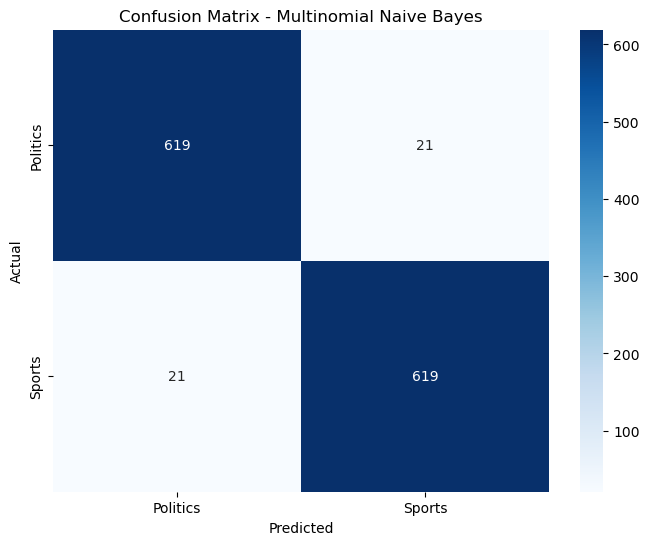

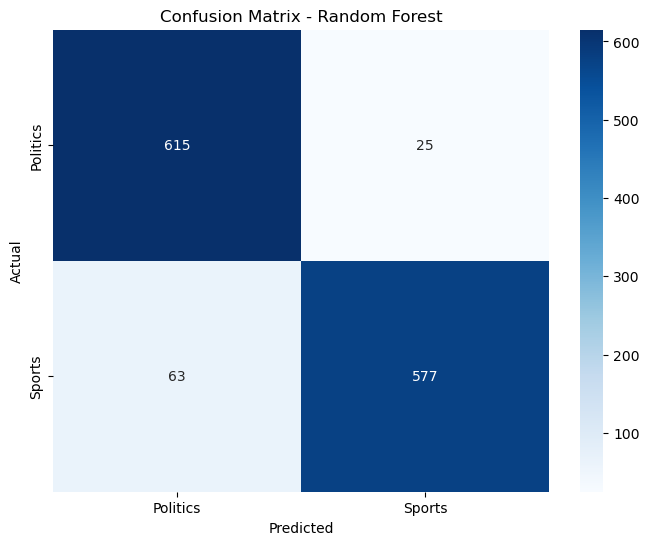

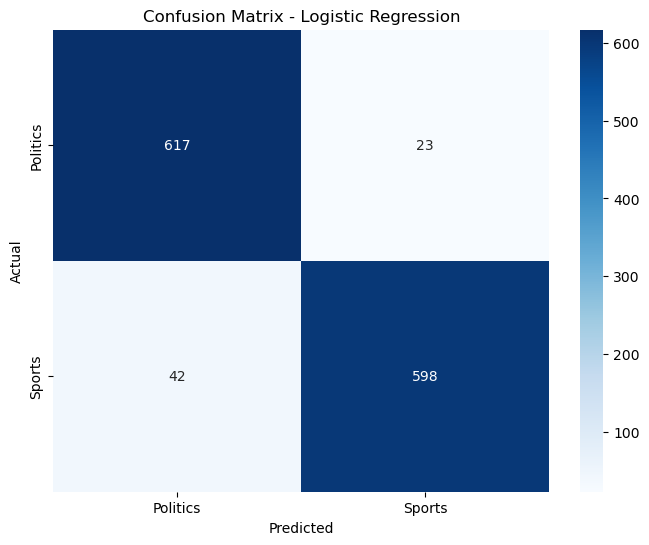

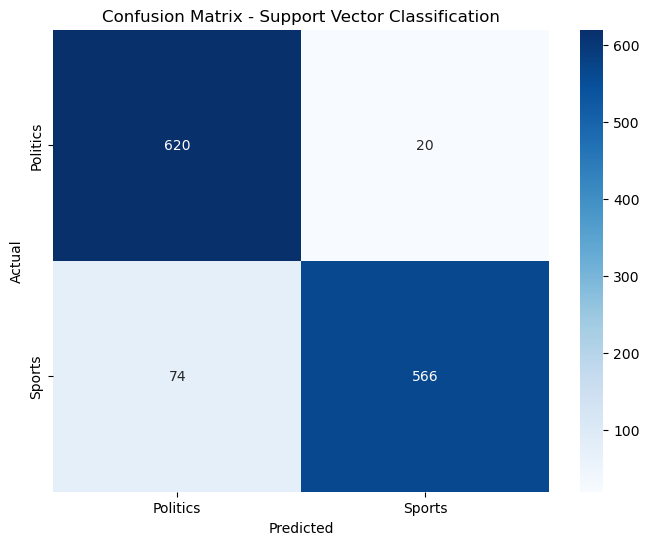

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Politics', 'Sports'], yticklabels=['Politics', 'Sports'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrix for Multinomial Naive Bayes
plot_confusion_matrix(y_test, y_pred_NB, 'Confusion Matrix - Multinomial Naive Bayes')

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_RF, 'Confusion Matrix - Random Forest')

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_LR, 'Confusion Matrix - Logistic Regression')

# Plot confusion matrix for Support Vector Classification
plot_confusion_matrix(y_test, y_pred_SVC, 'Confusion Matrix - Support Vector Classification')


## Hyper-parameter Tuning

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Preprocess text data
vectorizer = TfidfVectorizer()  # You can customize options here
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    # Add other hyperparameters here
}

# Create GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_tfidf, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_

# Evaluate model with best hyperparameters
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test_tfidf, y_test)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9265625


In [72]:
test_data = pd.read_csv('test.csv')

test_data['Prepro_TweetText'] = test_data['TweetText'].apply(PreprocessingTweet)

test_data['Label'] = 'Politics'  

test_data['Label'] = MultinomialNB_model.predict(test_data['Prepro_TweetText'])

test_data[['TweetText', 'Label']]


,TweetText,Label
0,'28. The home side threaten again through Maso...,0
1,'@mrbrown @aulia Thx for asking. See http://t....,1
2,'@Sochi2014 construction along the shores of t...,1
3,'#SecKerry\u2019s remarks after meeting with F...,1
4,'The #IPLauction has begun. Ricky Ponting is t...,0
...,...,...
2605,'Qualifier 1 and Eliminator games will be play...,0
2606,"@reesedward Hi Edward, it's not a #peacekeepin...",0
2607,'Perera was @SunRisersIPL first #IPL purchase ...,0
2608,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",1


In [67]:
# Map encoded labels to class names
label_map = {0: 'Sports', 1: 'Politics'}
test_data['Label'] = test_data['Label'].map(label_map)

In [69]:
test_data[['TweetText', 'Label']]

,TweetText,Label
0,'28. The home side threaten again through Maso...,Sports
1,'@mrbrown @aulia Thx for asking. See http://t....,Politics
2,'@Sochi2014 construction along the shores of t...,Politics
3,'#SecKerry\u2019s remarks after meeting with F...,Politics
4,'The #IPLauction has begun. Ricky Ponting is t...,Sports
...,...,...
2605,'Qualifier 1 and Eliminator games will be play...,Sports
2606,"@reesedward Hi Edward, it's not a #peacekeepin...",Sports
2607,'Perera was @SunRisersIPL first #IPL purchase ...,Sports
2608,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",Politics
